# Entanglement

## Quantum Teleportation

## Background
Usage estimate: 4 seconds on ibm_nairobi(NOTE; This is an estimate only. Your runtime may
vary)

In order to demonstrate Quantum teleportation we are required to prepare an entangled and one unknown state. The entangled state is shared between Alice and Bob. The unknown state is held by Alice. The goal is to teleport the unknown state to Bob.

Here, we demonstrate how to construct the teleportation circuit using the gates from the Qiskit library.

### Requirements
Before starting this tutorial, ensure that you have the following installed:
- Qiskit SDK 1.0 or later, with visualization support (pip install 'qiskit[visualization]')
- Qiskit Runtime (pip install qiskit-ibm-runtime) 0.22 or later

## Setup
Here we import the small number of tools we need for this tutorial

In [2]:
#Built-in modules
import math

#imports from Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_distribution

#Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [3]:
# To run on hardware, selectthe backedn with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_sherbrooke'

## Step 1: Map classical inputs to a quantum problem

In [4]:
# Required imports

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

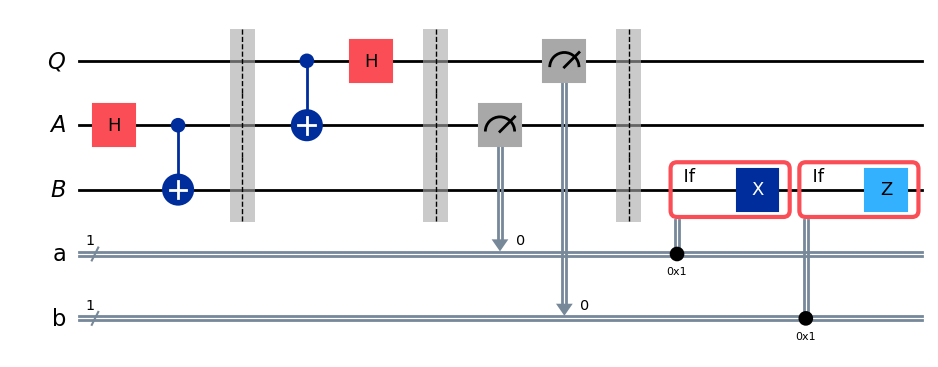

In [5]:
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

display(protocol.draw('mpl'))

The circuit makes use of a few features of Qiskit that we've not yet seen in previous lessons, including the barrier and if_test functions. The barrier function creates a visual separation making the circuit diagram more readable, and it also prevents Qiskit from performing various simplifications and optimizations across barriers during compilation when circuits are run on real hardware. The if_test function applies an operation conditionally depending on a classical bit or register.

The circuit first initializes 
$(A,B)$ to be in a $\ket{\varphi^+}$ state (which is not part of the protocol itself), followed by Alice's operations, then her measurements, and finally Bob's operations.

To test that the protocol works correctly, we'll apply a randomly generated single-qubit gate to the initialized $\ket{0}$ state of $Q$ to obtain a random quantum state vector to be teleported. By applying the inverse (i.e., conjugate transpose) of that gate to B after the protocol is run, we can verify that the state was teleported by measuring to see that it has returned to the $\ket{0}$ state.

First we'll randomly choose a unitary qubit gate.

In [6]:
random_gate = UGate(
    theta=random.random() * 2 * pi,
    phi=random.random() * 2 * pi,
    lam=random.random() * 2 * pi,
)

display(random_gate.to_matrix())

array([[ 0.28590584+0.j        ,  0.92699068-0.24278823j],
       [ 0.95702405+0.04860881j, -0.27989547+0.05831535j]])

Now we'll create a new testing circuit that first applies our random gate to Q, then runs the teleportation circuit,and finally applies the inverse of our random gate to the qubit B and measures. The outcome should be 0 with certainty.

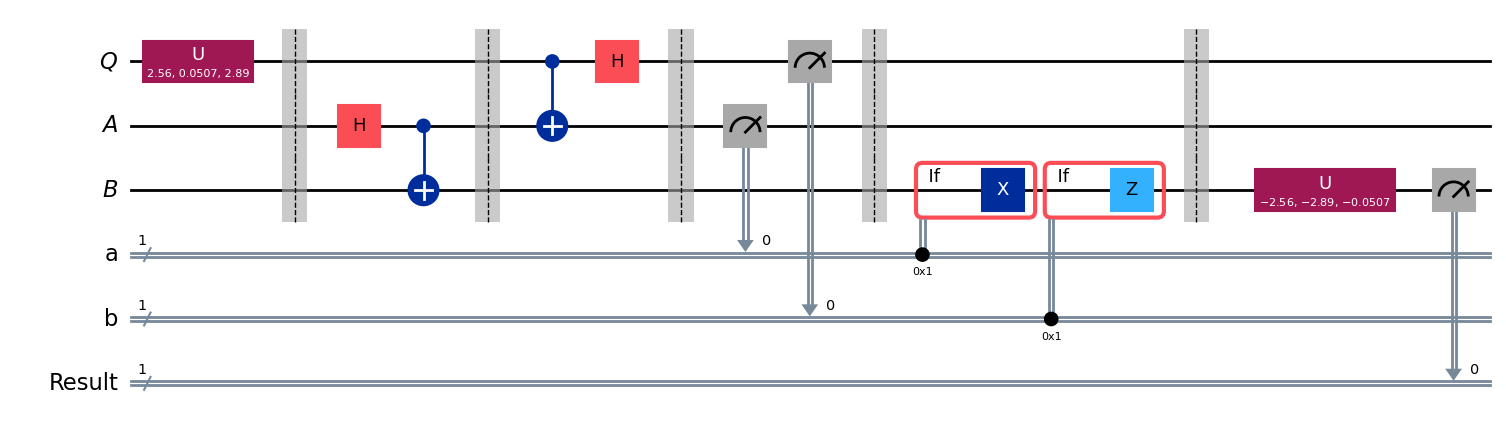

In [7]:
# Create a new circuit including the same bits and qubits used in the
# teleportation protocol.

test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Start with the randomly selected gate on Q

test.append(random_gate, qubit)
test.barrier()

# Append the entire teleportation protocol from above.

test = test.compose(protocol)
test.barrier()

# Finally, apply the inverse of the random unitary to B and measure.

test.append(random_gate.inverse(), ebit1)

result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

display(test.draw('mpl'))

Finally let's run the Aer simulator on this circuit and plot a histogram of the outputs. We'll see the statistics for all three classical bits: the bottom/leftmost bit should always be 0, indicating that the qubit Q was successfully teleported into B, while the other two bits should be roughly uniform.

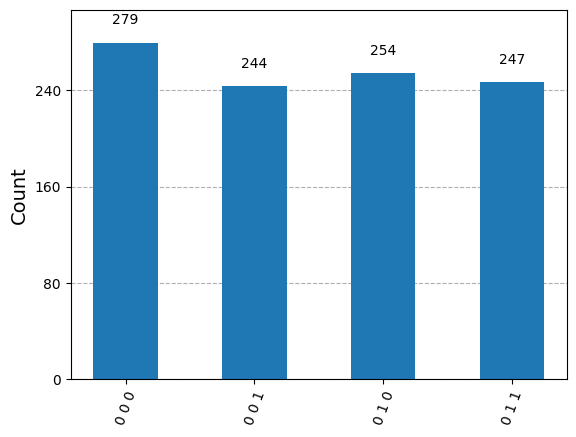

In [8]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

We can also filter the statistics to focus just on the test result qubit if we wish, like this:

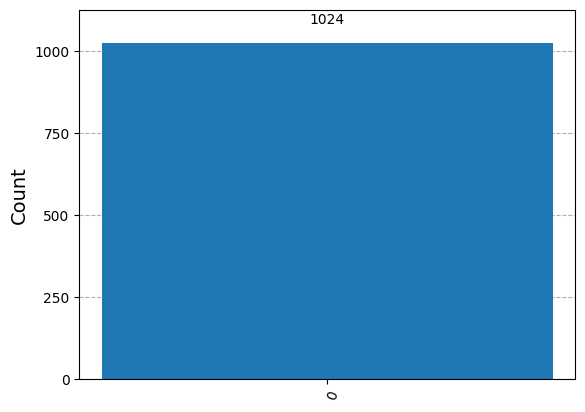

In [9]:
filtered_statistics = marginal_distribution(statistics, [2])
display(plot_histogram(filtered_statistics))

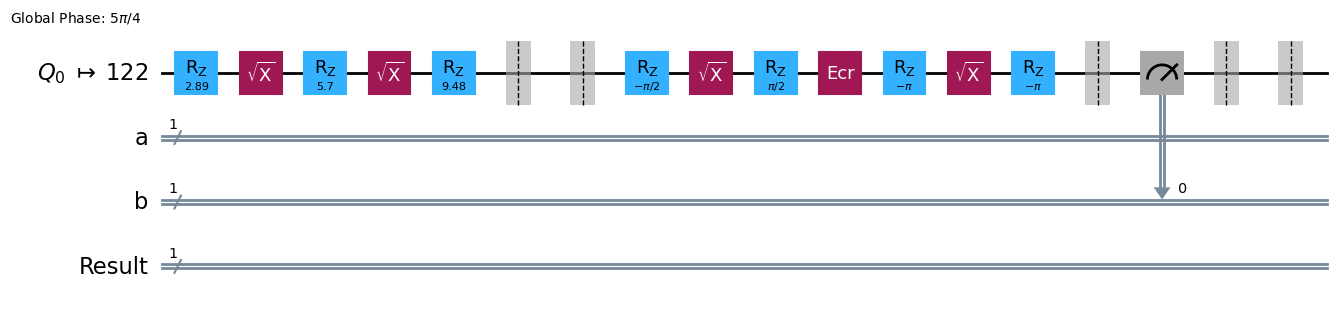

In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target=backend.target
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

circuit_isa=pm.run(test)
circuit_isa.draw(output="mpl",idle_wires=False,style="iqp")

In [11]:
# TO run on local simulator:
#1. Use the StatevectorSampler from qiskit.primitves instead
from qiskit.primitives import StatevectorSampler
sampler=Sampler(backend=backend)
#sampler=StatevectorSampler()
sampler.options.default_shots=10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.c.get_counts()

C:\Users\nihar\AppData\Local\Temp\ipykernel_32704\246611712.py:4: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler=Sampler(backend=backend)


AttributeError: 'DataBin' object has no attribute 'c'

In [ ]:
from qiskit.visualization import plot_histogram
plot_histogram(dist)

## Superdense coding

## Background
Usage estimate: 4 seconds on ibm_nairobi(NOTE; This is an estimate only. Your runtime may
vary)

In order to demonstrate Quantum teleportation we are required to prepare an entangled and one unknown state. The entangled state is shared between Alice and Bob. The unknown state is held by Alice. The goal is to teleport the unknown state to Bob.

Here, we demonstrate how to construct the teleportation circuit using the gates from the Qiskit library.

### Requirements
Before starting this tutorial, ensure that you have the following installed:
- Qiskit SDK 1.0 or later, with visualization support (pip install 'qiskit[visualization]')
- Qiskit Runtime (pip install qiskit-ibm-runtime) 0.22 or later

## Setup
Here we import the small number of tools we need for this tutorial

In [11]:
#Built-in modules
import math

#imports from Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_distribution

#Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [12]:
# To run on hardware, selectthe backedn with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_kyoto'

## Step 1: Map classical inputs to a quantum problem

In [13]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_bloch_multivector, array_to_latex
from qiskit.quantum_info import random_statevector
from qiskit.primitives import StatevectorSampler

In [18]:
def superdense_circuit(string):
    # Create a Quantum Circuit
    qubits=QuantumRegister(2,name="q")
    cbits=ClassicalRegister(2,name="c")
    circuit = QuantumCircuit(qubits,cbits)
    
    q0,q1=qubits
    c0,c1=cbits

    # Prepare the state to be teleported
    circuit.h(q0)
    circuit.cx(q0, q1)

    circuit.barrier()

    if string[0]=="1":
        circuit.z(q0)
    if string[1]=="1":
        circuit.x(q0)

    circuit.barrier()
    
    circuit.cx(q0, q1)
    circuit.h(q0)

    circuit.barrier()
    
    circuit.measure(q0, c0)
    circuit.measure(q1, c1)

    return circuit

In [22]:
qc_00=superdense_circuit("00")
qc_01=superdense_circuit("01")
qc_10=superdense_circuit("10")
qc_11=superdense_circuit("11")

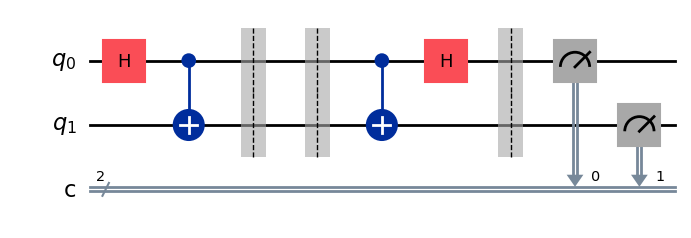

In [23]:
qc_00.draw('mpl')

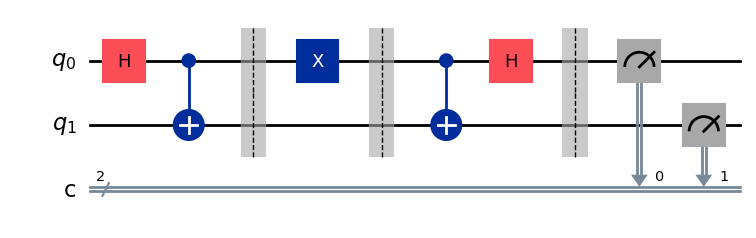

In [24]:
qc_01.draw('mpl')

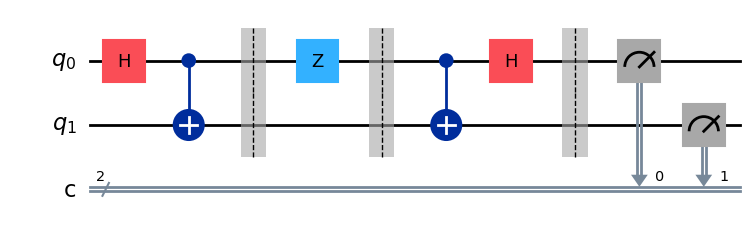

In [25]:
qc_10.draw('mpl')

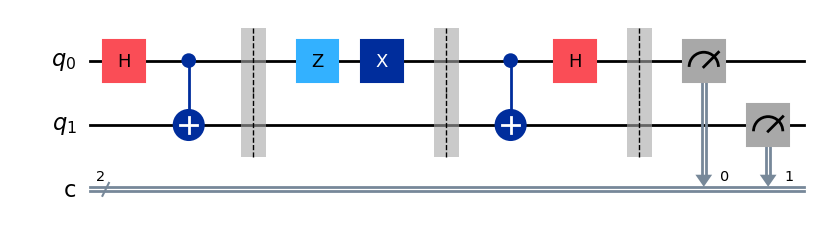

In [27]:
qc_11.draw('mpl')

## Step 2: Optimize problem for quantum execution

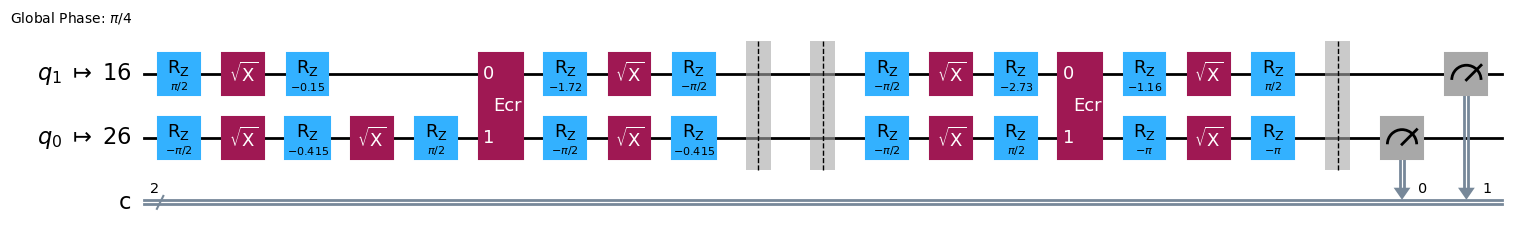

In [28]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target=backend.target
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

circuit_isa_00=pm.run(qc_00)
circuit_isa_00.draw(output="mpl",idle_wires=False,style="iqp")

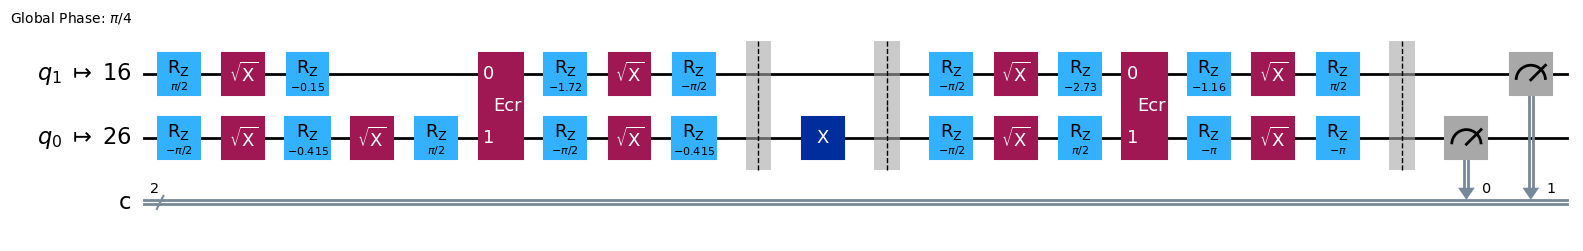

In [29]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target=backend.target
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

circuit_isa_01=pm.run(qc_01)
circuit_isa_01.draw(output="mpl",idle_wires=False,style="iqp")

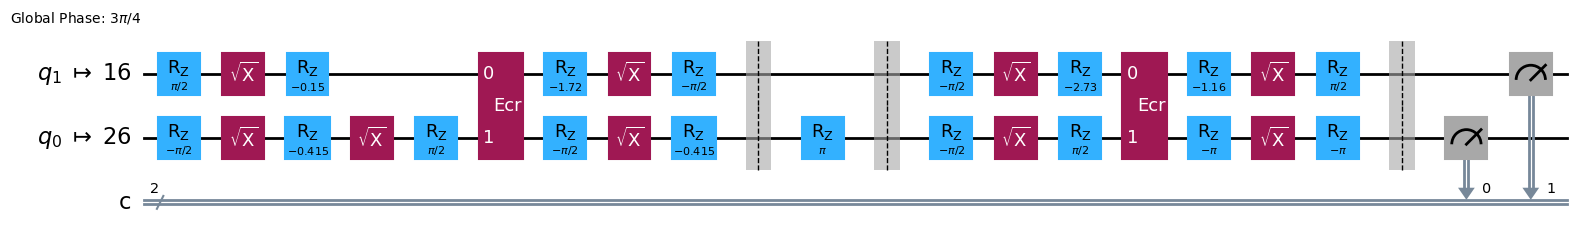

In [30]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target=backend.target
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

circuit_isa_10=pm.run(qc_10)
circuit_isa_10.draw(output="mpl",idle_wires=False,style="iqp")

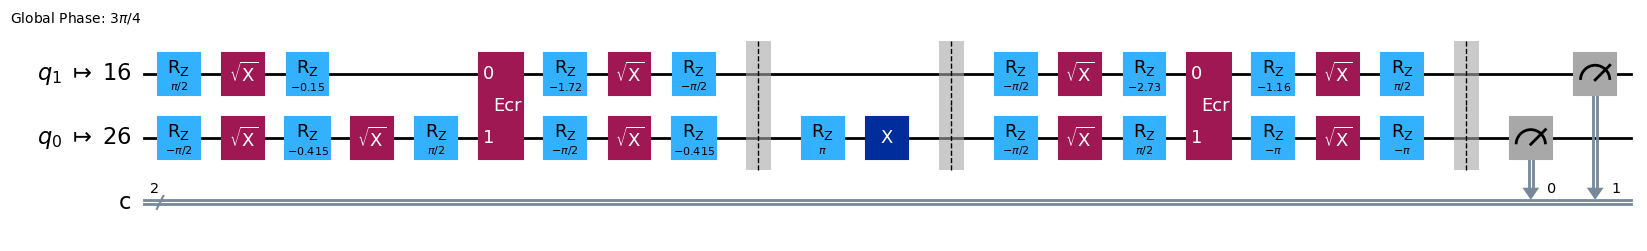

In [31]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target=backend.target
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

circuit_isa_11=pm.run(qc_11)
circuit_isa_11.draw(output="mpl",idle_wires=False,style="iqp")

## Step 3: Execute using Qiskit Primitives

We are now required to run the circuit and sample the measurements on th first qubit thus for execution we will use the Sampler runtime primitive.

In [32]:
# TO run on local simulator:
#1. Use the StatevectorSampler from qiskit.primitves instead
sampler=Sampler(backend=backend)
sampler.options.default_shots=10_000
result_00 = sampler.run([circuit_isa_00]).result()
dist_00 = result_00[0].data.c.get_counts()

C:\Users\nihar\AppData\Local\Temp\ipykernel_8676\30366168.py:3: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler=Sampler(backend=backend)


In [33]:
# TO run on local simulator:
#1. Use the StatevectorSampler from qiskit.primitves instead
sampler=Sampler(backend=backend)
sampler.options.default_shots=10_000
result_01 = sampler.run([circuit_isa_01]).result()
dist_01 = result_01[0].data.c.get_counts()

C:\Users\nihar\AppData\Local\Temp\ipykernel_8676\973544588.py:3: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler=Sampler(backend=backend)


In [34]:
# TO run on local simulator:
#1. Use the StatevectorSampler from qiskit.primitves instead
sampler=Sampler(backend=backend)
sampler.options.default_shots=10_000
result_10 = sampler.run([circuit_isa_10]).result()
dist_10 = result_10[0].data.c.get_counts()

C:\Users\nihar\AppData\Local\Temp\ipykernel_8676\3799579754.py:3: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler=Sampler(backend=backend)


In [35]:
# TO run on local simulator:
#1. Use the StatevectorSampler from qiskit.primitves instead
sampler=Sampler(backend=backend)
sampler.options.default_shots=10_000
result_11 = sampler.run([circuit_isa_11]).result()
dist_11 = result_11[0].data.c.get_counts()

C:\Users\nihar\AppData\Local\Temp\ipykernel_8676\2087583879.py:3: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler=Sampler(backend=backend)


## Step 4: Post-Process, reutrn result in Classical format

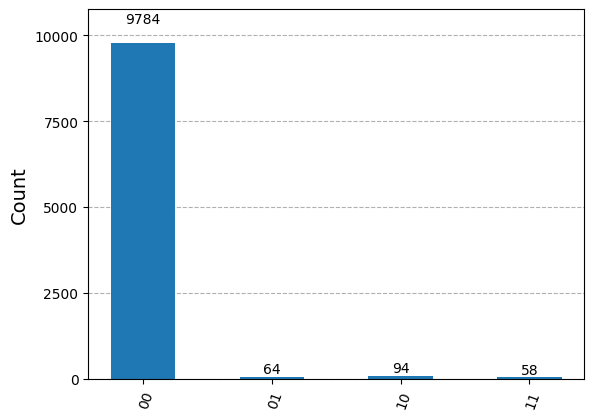

In [37]:
from qiskit.visualization import plot_histogram
plot_histogram(dist_00)

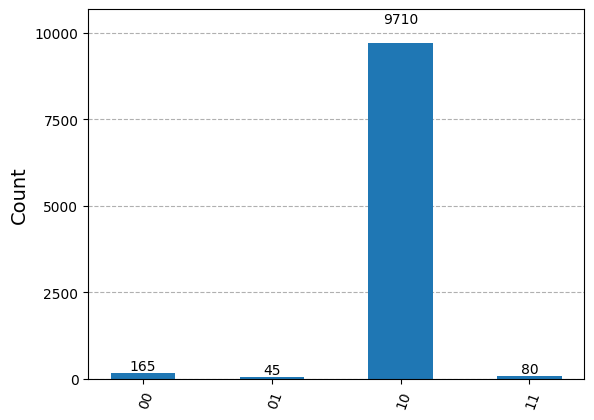

In [38]:
plot_histogram(dist_01)

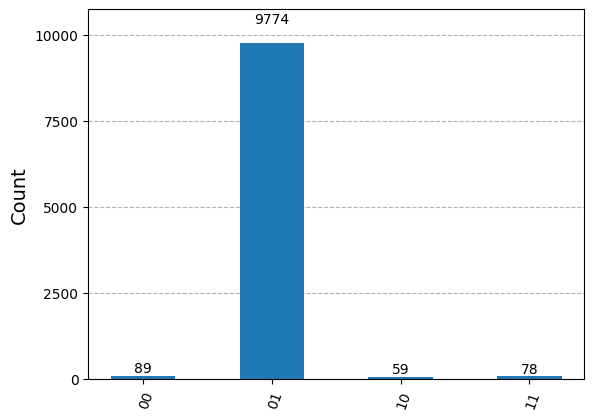

In [39]:
plot_histogram(dist_10)

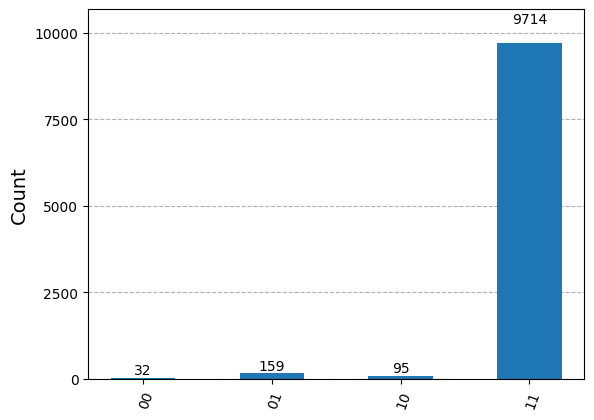

In [40]:
plot_histogram(dist_11)